# Remaining Useful Life Prediction
Documentation: https://developer.ibm.com/tutorials/awb-foundation-model-time-series-forecasting/

In [251]:
!git clone "https://github.com/ibm-granite/granite-tsfm.git"
#%cd granite-tsfm
#!pip install ".[notebooks]"
#%cd ../


fatal: destination path 'granite-tsfm' already exists and is not an empty directory.


In [252]:
# Core libraries
import os
import math
import tempfile
import torch
from torch.optim import AdamW
from torch.optim.lr_scheduler import OneCycleLR
from transformers import EarlyStoppingCallback, Trainer, TrainingArguments, set_seed
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# TSFM libraries
from tsfm_public.models.tinytimemixer import TinyTimeMixerForPrediction
from tsfm_public.toolkit.callbacks import TrackingCallback
from tsfm_public import (
    TimeSeriesPreprocessor,
    TinyTimeMixerForPrediction,
    TrackingCallback,
    count_parameters,
    get_datasets,
)

# TSFM Toolkit libraries
from tsfm_public.toolkit.util import select_by_index
from tsfm_public.toolkit.time_series_forecasting_pipeline import TimeSeriesForecastingPipeline
from tsfm_public.toolkit.visualization import plot_ts_forecasting

# Weights and Biases (WANB) API Key:
# 55786691f5bf98d3d3c2974925c51b1e1622d1d3

In [253]:
# Load datasets
with open('../data/processed_data_pickle_files_with_smoothing/test_data_no_batches.pkl', 'rb') as file:
    test_df = pickle.load(file)

with open('../data/processed_data_pickle_files_with_smoothing/test_data_no_batches.pkl', 'rb') as file:
    train_df = pickle.load(file)

# Ensure data are dataframes
if not isinstance(test_df, pd.DataFrame):
    raise ValueError("Loaded data is not a pandas DataFrame.")

if not isinstance(train_df, pd.DataFrame):
    raise ValueError("Loaded data is not a pandas DataFrame.")

column_names = ['unit_number', 'sensor_2', 'sensor_3', 'sensor_4',
       'sensor_6', 'sensor_7', 'sensor_8', 'sensor_9', 'sensor_11',
       'sensor_12', 'sensor_13', 'sensor_15', 'sensor_17', 'sensor_20',
       'sensor_21']

test_df.columns = column_names
train_df.columns = column_names

In [ ]:
# FOR DEVELOPMENT - FILTER TO 5 UNITS
#train_df = train_df[train_df['unit_number'] < 6]

In [255]:
# Add RUL values to the train_df dataframe (unknown for test_df)
train_df['RUL'] = train_df.groupby('unit_number')['unit_number'].transform(lambda x: np.arange(len(x), 0, -1))
#test_df['RUL'] = test_df.groupby('unit_number')['unit_number'].transform(lambda x: np.arange(len(x), 0, -1))

In [256]:
print(train_df.head(20))

    unit_number  sensor_2  sensor_3  sensor_4  sensor_6  sensor_7  sensor_8  \
0           1.0  1.922208 -0.904665 -1.228605  0.495998  0.292745 -0.659857   
1           1.0  0.754317 -0.650760 -1.324650  0.495998  0.697198 -0.791728   
2           1.0 -0.057943 -0.468470 -1.344393  0.495998  0.957741 -0.856090   
3           1.0 -0.716104 -0.323225 -1.328357  0.495998  1.156672 -0.895388   
4           1.0 -1.011783 -0.272023 -1.225044  0.495998  1.211535 -0.880535   
5           1.0 -1.016215 -0.309541 -1.045663  0.495998  1.152273 -0.831335   
6           1.0 -0.860066 -0.412481 -0.818333  0.495998  1.033067 -0.776875   
7           1.0 -0.615236 -0.551412 -0.579687  0.495998  0.890446 -0.742218   
8           1.0 -0.365642 -0.685458 -0.371569  0.495998  0.763754 -0.746241   
9           1.0 -0.182241 -0.782296 -0.218792  0.495998  0.680395 -0.792037   
10          1.0 -0.089516 -0.846035 -0.159361  0.495998  0.645641 -0.872490   
11          1.0 -0.092452 -0.905724 -0.220310  0.495

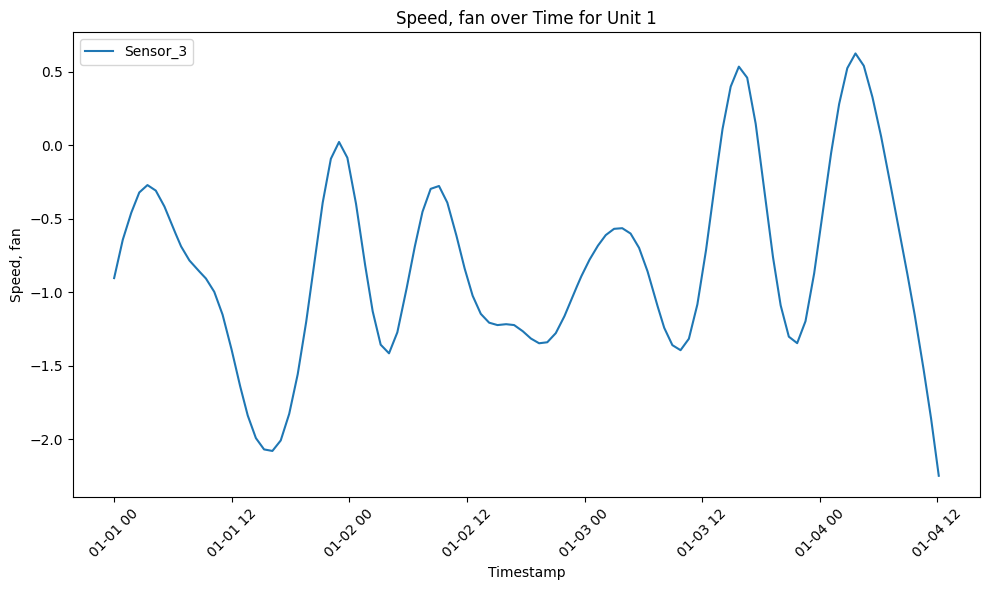

In [257]:
# Step 1 & 2: Efficiently add empty rows and timestamp for each unit_number
def expand_and_add_timestamp(df, num_empty_rows=50, start_date='2023-01-01'):
    dfs = []
    for unit_num, group in df.groupby('unit_number'):
        N = len(group)
        total_rows = N + (N - 1) * num_empty_rows
        # Create timestamps starting at midnight for each unit_number
        timestamps = pd.date_range(start=start_date, periods=total_rows, freq='min')
        # Create an empty DataFrame with timestamps
        expanded_group = pd.DataFrame({'timestamp': timestamps})
        # Calculate positions to insert the original data
        positions = np.arange(N) * (num_empty_rows + 1)
        # Assign unit_number to the expanded DataFrame
        expanded_group['unit_number'] = unit_num
        # Insert the original data into the correct positions
        expanded_group.loc[positions, group.columns] = group.values
        dfs.append(expanded_group)
    expanded_df = pd.concat(dfs, ignore_index=True)
    return expanded_df

# Step 3: Interpolate the missing values for each unit_number
def interpolate_missing_values(df):
    df = df.set_index(['unit_number', 'timestamp'])
    df = df.interpolate(method='linear')
    df = df.reset_index()
    return df


# Apply the steps to train_df
train_df = expand_and_add_timestamp(train_df)
train_df = interpolate_missing_values(train_df)

# Step 4: Plot 'Speed, fan' for unit_number = 1 over timestamp column
unit_1_data = train_df[train_df['unit_number'] == 1]
plt.figure(figsize=(10, 6))
plt.plot(unit_1_data['timestamp'], unit_1_data['sensor_3'], label='Sensor_3')
plt.xlabel('Timestamp')
plt.ylabel('Speed, fan')
plt.title('Speed, fan over Time for Unit 1')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [258]:
# Refine dataset
train_df = train_df.dropna()
train_df.columns

Index(['unit_number', 'timestamp', 'sensor_2', 'sensor_3', 'sensor_4',
       'sensor_6', 'sensor_7', 'sensor_8', 'sensor_9', 'sensor_11',
       'sensor_12', 'sensor_13', 'sensor_15', 'sensor_17', 'sensor_20',
       'sensor_21', 'RUL'],
      dtype='object')

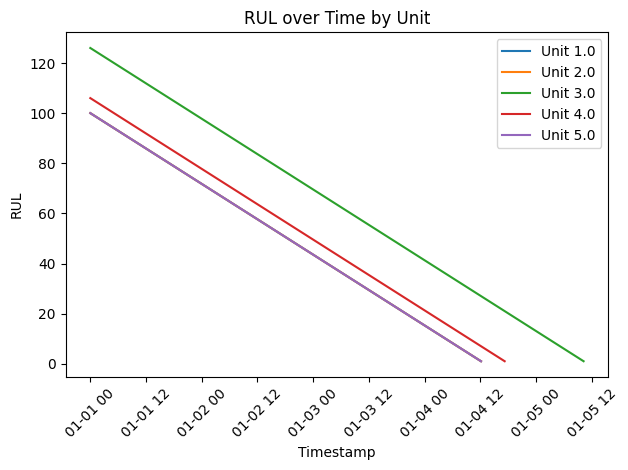

In [259]:
# Plot RUL over time for each unit in the dataset

# Loop through each unique unit number and plot separately
for unit in train_df['unit_number'].unique():
    unit_data = train_df[train_df['unit_number'] == unit]
    plt.plot(unit_data['timestamp'], unit_data['RUL'], label=f'Unit {unit}')

# Add labels and title
plt.xlabel('Timestamp')
plt.ylabel('RUL')
plt.title('RUL over Time by Unit')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


# Forecasting

In [260]:
# Generate train/validation/test split configurations for each unit number in the dataset.
def generate_split_configs(input_df, context_length, unit_numbers=None):

    # If no unit numbers provided, get all unique unit numbers from the data
    if unit_numbers is None:
        unit_numbers = train_df['unit_number'].unique()

    split_configs = {}

    for unit in unit_numbers:
        # Filter data for current unit
        unit_data = input_df[input_df['unit_number'] == unit]
        #unit_data = unit_data.reset_index(drop=True)
        data_length = len(unit_data)

        # Calculate indices for train split (0 to 80%)
        train_start_index = 0
        train_end_index = round(data_length * 0.8)

        # Calculate indices for validation split (80% to 90%)
        # Shift back by context length to ensure first evaluation timestamp follows training data
        eval_start_index = round(data_length * 0.8) - context_length
        eval_end_index = round(data_length * 0.9)

        # Calculate indices for test split (90% to end)
        test_start_index = round(data_length * 0.9) - context_length
        test_end_index = data_length - 1

        # Create split configuration for current unit
        split_configs[unit] = {
            "train": [train_start_index, train_end_index],
            "valid": [eval_start_index, eval_end_index],
            "test": [test_start_index, test_end_index]
        }

    return list(split_configs.values())

In [261]:
# Function to determine actual vs predicted values
def compare_forecast(forecast, date_col, prediction_col, actual_col, hours_out):
  comparisons = pd.DataFrame()
  comparisons[date_col] = forecast[date_col]
  actual = []
  pred = []

  for i in range(len(forecast)):
    pred.append(forecast[prediction_col].values[i][hours_out - 1]) # prediction for next day
    actual.append(forecast[actual_col].values[i][hours_out - 1])

  comparisons['actual'] = actual
  comparisons['pred'] = pred

  return comparisons

In [262]:
print(train_df.columns)

Index(['unit_number', 'timestamp', 'sensor_2', 'sensor_3', 'sensor_4',
       'sensor_6', 'sensor_7', 'sensor_8', 'sensor_9', 'sensor_11',
       'sensor_12', 'sensor_13', 'sensor_15', 'sensor_17', 'sensor_20',
       'sensor_21', 'RUL'],
      dtype='object')


In [263]:
# Set seed for reproducibility
SEED = 42
set_seed(SEED)

# Forecasting parameters
context_length = 512 # TTM can use 512 time points into the past
forecast_length = 96 # TTM can predict 96 time points into the future
fewshot_fraction = 0.05 # 5% of the data can be used for few-shot

# Results directory
#OUT_DIR = "ttm_finetuned_models/"

# Set column parameters
timestamp_column = "timestamp"
target_columns = ["RUL"]
observable_columns = train_df.columns[2:-1]   # Exclude 'unit_number' and 'RUL' columns

# Set up Column Specifiers and Preprocessor
column_specifiers = {
    "timestamp_column": timestamp_column,
    "target_columns": target_columns,
    "observable_columns": observable_columns
}

In [ ]:
# Forecast each unit's RUL
# Assuming the necessary variables (e.g., train_df, context_length, units, tsp, timestamp_column, target_columns) are defined

units = np.arange(1,101)
unit_list = []
rmse_list = []
split_configs = generate_split_configs(train_df, context_length, unit_numbers=units)

for unit in units:
    df_subset = train_df[train_df['unit_number'] == unit]
    df_subset = df_subset.reset_index(drop=True)
    split_config = split_configs[unit - 1]  # Access by index

    '''
    # Run data checks for debug
    print(split_config)
    print(len(df_subset))
    if df_subset is None or len(df_subset) == 0:
        print(f"No data available for unit {unit}")
    else:
        print(f"Dataset for unit {unit} is good")
    '''


    # Reset Preprocessor
    tsp = TimeSeriesPreprocessor(
      **column_specifiers,
      context_length=context_length,
      prediction_length=forecast_length,
      scaling=False,
      encode_categorical=True,
      scaler_type="standard",
    )
    
    # Generate datasets based on the split configuration
    train_dataset, valid_dataset, test_dataset = get_datasets(tsp, dataset=df_subset, split_config=split_config)

    
    # Assign the zeroshot model
    zeroshot_model = TinyTimeMixerForPrediction.from_pretrained("ibm/TTM", revision="main", prediction_filter_length=24)

    # Initialize trainer with the model
    zeroshot_trainer = Trainer(
        model=zeroshot_model,
    )

    # Evaluate the model on the test dataset
    zeroshot_trainer.evaluate(test_dataset)

    # Create a forecasting pipeline
    zs_forecast_pipeline = TimeSeriesForecastingPipeline(
        model=zeroshot_model,
        device="cpu",
        timestamp_column=timestamp_column,
        id_columns=[],  # Adjust id_columns if needed
        target_columns=target_columns,
        freq="1m"
    )

    # Retrieve test data start and end indices
    test_start_index, test_end_index = split_config['test']

    # Generate forecast
    processed_data = tsp.preprocess(train_df[test_start_index:test_end_index])
    zs_forecast = zs_forecast_pipeline(processed_data)

    # Compare forecast with actual data and prepare for plotting
    df = compare_forecast(zs_forecast, "timestamp", "RUL_prediction", "RUL", 12)
    df.dropna(inplace=True)

    '''
    # Plot actual vs. predicted values
    plt.figure(figsize=(10, 6))
    plt.plot(df['timestamp'], df['actual'], label='Actual', linestyle='-', marker='o')
    plt.plot(df['timestamp'], df['pred'], label='Pred', linestyle='-', marker='o')

    # Add labels and legend
    plt.xlabel('Timestamp')
    plt.ylabel('Values')
    plt.title('Actual vs Pred over Time - Unit ' + str(unit))
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    '''

    # Calculate RMSE for the unit
    rmse = np.sqrt(mean_squared_error(df['actual'], df['pred']))
    print(f"RMSE for Unit {unit}: {rmse}")
    unit_list.append(unit)
    rmse_list.append(rmse)
    #print("======================================================")
    

  0%|          | 0/116 [00:00<?, ?it/s]

RMSE for Unit 1: 0.061445154962221714


  0%|          | 0/116 [00:00<?, ?it/s]

RMSE for Unit 2: 0.061445154962221714


  0%|          | 0/132 [00:00<?, ?it/s]

RMSE for Unit 3: 0.061443572777432


  0%|          | 0/119 [00:00<?, ?it/s]

RMSE for Unit 4: 1.6095070096720263


  0%|          | 0/116 [00:00<?, ?it/s]

RMSE for Unit 5: 0.061445154962221714


ValueError: At least one of start_fraction or end_fraction must be specified.